In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('classic')
import numpy as np
import datetime as dt
from datetime import timedelta
import simulate
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 100)

In [2]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

start = dt.date(2020, 1, 1)
end = dt.date(2080, 1, 31)


Market = simulate.Market(spx.iloc[-7500:, -2], start, end)

## Setting up functions to calculate performance

In [41]:
def determine_investment(phase, pv_u, tv_u, s, td, pi_rf, dst, g):
    
    # returns cash, new_equity, new_debt
    
    if phase == 1:
        new_debt = min(max(g*s, g*(pv_u-td)), dst-pv_u-s)
        return 0, s, new_debt
    
    if phase == 2: 
        stocks_sold = max(pv_u-dst, 0)
        debt_repayment = min(td, s + stocks_sold)
        leftover_savings = max(s-debt_repayment - stocks_sold, 0)
        return 0, leftover_savings, -debt_repayment
    
    if phase == 3:
        return 0, s, 0
    
    if phase == 4:
        desired_cash = (1-pi_rf)*(tv_u+s)
        desired_savings = (pi_rf)*(tv_u+s)
        change_in_stock = desired_savings - pv_u
        return desired_cash, change_in_stock, 0

In [5]:
def phase_check(phase, pi_rf, pi_rm, pi_hat, td):
    if phase == 4:
        return 4
    
    if td > 0:
        #has target not been reached?
        if pi_hat < pi_rm and phase <= 1:
            return 1
        else:
            # if target has been reached once and debt remains, stay in phase 2
            return 2
    
    #if target has been reached and no debt remains
    #is the value still above the target?
    if pi_hat < pi_rf:
        return 3
    else:
        return 4

In [6]:
def calc_pi(gamma, sigma, mr, rate, cost = 0):
    return (mr - cost - rate)/(gamma * sigma)

In [7]:
# Should be 175, -25
update_cash(4, 900, 1000, 50, 100, (1/1.2), 0.9)

(174.99999999999997, -25.0)

## Combining with investment profile

In [44]:
def calculate_return(savings, market_returns, gearing_cap, pi_rf, pi_rm, rf, rm):
    
    # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    # Setting up constants and dataframe for calculation
    ses = savings.sum()     # Possibly add more sophisticated discounting
    ist = pi_rm*ses
    columns = ['period', 'savings', 'cash', 'new_equity', 'new_debt', 'total_debt', 'nip', 'pv_p', 
               'interest', 'market_returns', 'pv_u', 'tv_u', 'dst', 'phase', 'pi_hat', 'ses']
    
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)
    
    pp['ses'] = ses
    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    
                      
    # Period 0 primo
    pp.loc[0, 'cash'] = 0
    pp.loc[0, 'new_equity'] = pp.loc[0, 'savings']
    pp.loc[0, 'new_debt'] = pp.loc[0, 'new_equity']*gearing_cap
    pp.loc[0, 'total_debt'] = pp.loc[0, 'new_debt']
    pp.loc[0, 'nip'] = pp.loc[0, 'new_debt'] + pp.loc[0, 'new_equity']
    pp.loc[0, 'pv_p'] = pp.loc[0, 'nip']
    pp.loc[0, 'pi_hat'] =  pp.loc[0, 'pv_p']/ses
    
    # Period 0 ultimo
    pp.loc[0, 'interest'] = pp.loc[0, 'new_debt']*rm                   
    pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']                 
    pp.loc[0, 'tv_u'] = pp.loc[0, 'pv_u'] + pp.loc[0, 'cash']
    pp.loc[0, 'dst'] = ist
    pp.loc[0, 'phase'] = 1
    
              
    
    # Looping over all reminaning periods
    for i in range(1, len(savings)):
 
        # Period t > 0 primo
        pp.loc[i, 'cash'] = pp.loc[i-1, 'cash']*(1+rf) 
        pp.loc[i, 'cash'], pp.loc[i, 'new_equity'], pp.loc[i, 'new_debt'] = determine_investment(
                                                                                     pp.loc[i-1, 'phase'], pp.loc[i-1, 'pv_u'], 
                                                                                     pp.loc[i-1, 'tv_u'], pp.loc[i, 'savings'], pp.loc[i-1, 'total_debt'],
                                                                                     pi_rf, pp.loc[i-1, 'dst'], gearing_cap)

        pp.loc[i, 'total_debt'] = pp.loc[i-1, 'total_debt'] + pp.loc[i, 'new_debt']
        pp.loc[i, 'nip'] = pp.loc[i, 'new_equity'] + max(0, pp.loc[i, 'new_debt'])
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'pv_u'] + pp.loc[i, 'nip']        
        
        
        
        # Period t > 0 ultimo
        pp.loc[i, 'interest'] = max(pp.loc[i, 'total_debt']*rm, 0)
        pp.loc[i, 'pv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])-pp.loc[i, 'interest']
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_u'] + pp.loc[i, 'cash']
        pp.loc[i, 'pi_hat'] = min(pp.loc[i, 'pv_u']/ses, pp.loc[i, 'pv_u']/pp.loc[i, 'tv_u'])
        
        pp.loc[i, 'phase'] = phase_check(pp.loc[i-1, 'phase'], pi_rf, pi_rm, pp.loc[i, 'pi_hat'], pp.loc[i, 'total_debt'])
        target_pi = pi_rm if pp.loc[i-1, 'phase'] < 3 else pi_rf
        pp.loc[i, 'dst'] = max(pp.loc[i, 'tv_u']*target_pi, ist)  # Moving stock target
        #pp.loc[i, 'dst'] = max(pp.loc[i-1, 'dst'], max(pp.loc[i, 'tv_u']*target_pi, ist))  # Locked stock target at highest previous position       

    return pp

In [45]:
def calculate100return(savings, market_returns):
     # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    columns = ['period', 'savings', 'pv_p', 'market_returns', 'tv_u']
        
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)
    
    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    pp.loc[0, 'pv_p'] = pp.loc[0, 'savings']
    pp.loc[0, 'tv_u'] = pp.loc[0, 'savings']
    
    for i in range(1, len(savings)):
 
        # Period t > 0 primo
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'tv_u'] + pp.loc[i, 'savings']        
        
        # Period t > 0 ultimo
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])
    
    return pp

In [46]:
def calculate9050return(savings, market_returns, rf):
    # Strategy where 90% of value is initially invested in stocks, rest in risk free asset
    # Ratio of stocks falls linearly to 50% by age 65 and stays there
    
    # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    columns = ['period',  'savings', 'cash', 'pv_p', 'market_returns', 'pv_u', 'tv_u', 'ratio']
        
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)

    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    pp.loc[0, 'pv_p'] = pp.loc[0, 'savings']*0.9
    pp.loc[0, 'cash'] = pp.loc[0, 'savings']*0.1
    pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']    
    pp.loc[0, 'tv_u'] = pp.loc[0, 'savings']
    pp.loc[0, 'ratio'] = 90
    
    for i in range(1, len(savings)):
        ratio = max(90 - pp.loc[i, 'period'], 50)
        pp.loc[i, 'ratio'] = ratio
        
        # Period t > 0 primo
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'pv_u'] + pp.loc[i, 'savings']*(ratio/100)        
        pp.loc[i, 'cash'] = pp.loc[i-1, 'cash']*(1+rf) + pp.loc[i, 'savings']*(1-ratio/100)
        
        # Period t > 0 ultimo
        pp.loc[i, 'pv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_u'] + pp.loc[i, 'cash']
    
    return pp

In [47]:
savings_year = pd.read_csv('investment_plan_year.csv', sep=';', index_col=0)
savings_year.index = pd.to_datetime(savings_year.index, format='%Y')
savings_month = (savings_year.resample('BMS').pad()/12)['Earnings'].values
savings_year = savings_year['Earnings'].values

In [48]:
yearly_rf = 0.02
yearly_rm = 0.03

# Set period
period = 'M'


if period == 'M':
    investments = savings_month*0.05
    rf = yearly_rf/12
    rm = yearly_rm/12
    freq = 'BMS'
else:
    investments = savings_year*0.05
    rf = yearly_rf
    rm = yearly_rm
    freq = 'BYS'


gamma = 1.5
sigma = 0.20**2
mr = 0.07

pi_rf = calc_pi(gamma, sigma, mr, yearly_rf, cost = 0)
pi_rm = calc_pi(gamma, sigma, mr, yearly_rm, cost = 0)
    
    
market = Market.garch(random_state = 69).asfreq(freq, 'pad')
  
      
port = calculate_return(investments, market['Price'].pct_change().values, 1, pi_rf, pi_rm, rf, rm)
port100 = calculate100return(investments, market['Price'].pct_change().values)
port9050 = calculate9050return(investments, market['Price'].pct_change().values, rf)

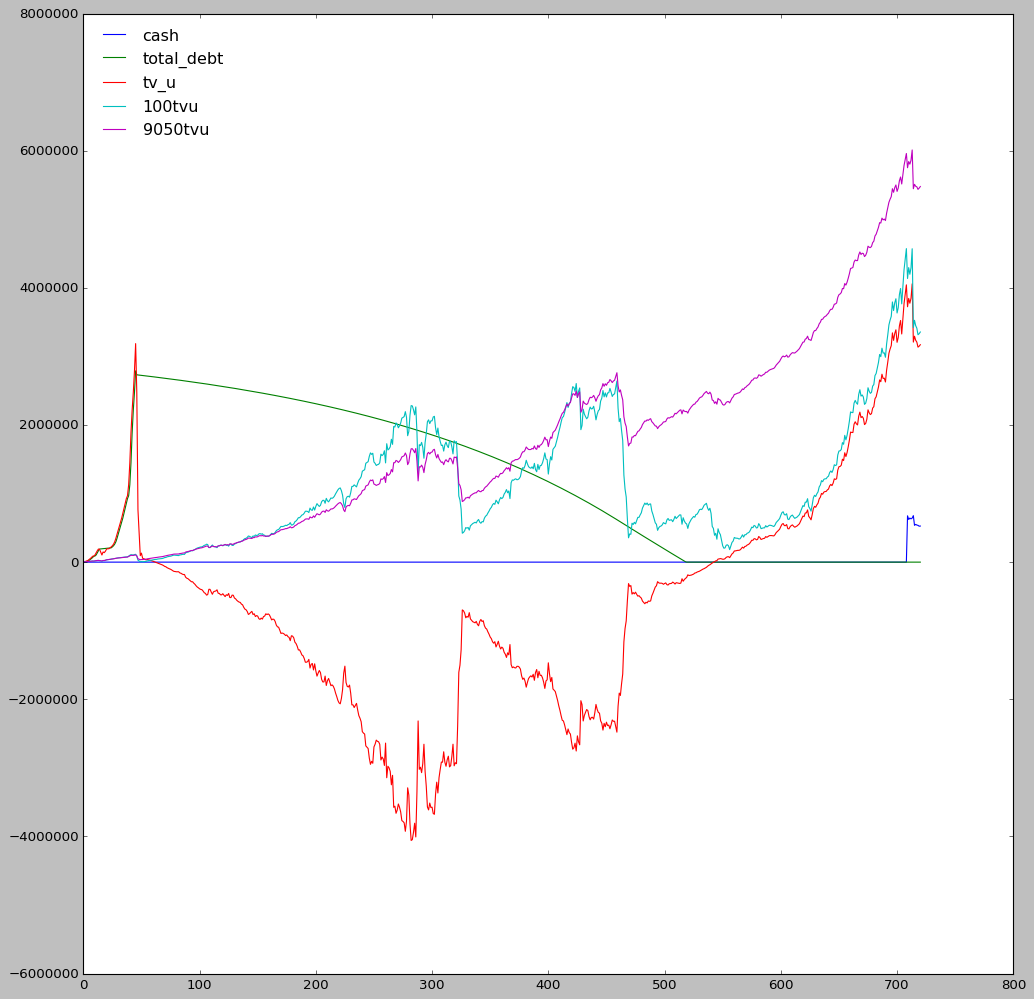

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
vars_to_plot = ['cash', 'total_debt', 'tv_u', '100tvu', '9050tvu']
port['100tvu'] = port100['tv_u']
port['9050tvu'] = port9050['tv_u']
ax.plot(port.loc[:,vars_to_plot])
#ax.set_yscale('log')
ax.legend(vars_to_plot, loc = 'upper left', frameon=False)

In [50]:
#plt.plot(port['new_equity'])
port.head(100)

,period,savings,cash,new_equity,new_debt,total_debt,nip,pv_p,interest,market_returns,pv_u,tv_u,dst,phase,pi_hat,ses,100tvu,9050tvu
0,0,"1,666.67",0.00,"1,666.67","1,666.67","1,666.67","3,333.33","3,333.33",4.17,0.00,"3,333.33","3,333.33","3,130,726.21",1.00,0.00,"4,696,089.32","1,666.67","1,666.67"
1,1,"1,666.67",0.00,"1,666.67","1,666.67","3,333.33","3,333.33","6,666.67",8.33,0.03,"6,831.70","6,831.70","3,130,726.21",1.00,0.00,"4,696,089.32","3,420.02","3,411.19"
2,2,"1,666.67",0.00,"1,666.67","3,498.37","6,831.70","5,165.04","11,996.74",17.08,-0.02,"11,699.88","11,699.88","3,130,726.21",1.00,0.00,"4,696,089.32","4,968.06","4,972.85"
3,3,"1,666.67",0.00,"1,666.67","4,868.17","11,699.88","6,534.84","18,234.72",29.25,-0.07,"16,862.74","16,862.74","3,130,726.21",1.00,0.00,"4,696,089.32","6,146.17","6,208.05"
4,4,"1,666.67",0.00,"1,666.67","5,162.86","16,862.74","6,829.53","23,692.26",42.16,0.08,"25,593.39","25,593.39","3,130,726.21",1.00,0.01,"4,696,089.32","8,453.66","8,439.73"
5,5,"1,666.67",0.00,"1,666.67","8,730.66","25,593.39","10,397.32","35,990.72",63.98,0.06,"38,076.59","38,076.59","3,130,726.21",1.00,0.01,"4,696,089.32","10,724.85","10,636.91"
6,6,"1,666.67",0.00,"1,666.67","12,483.20","38,076.59","14,149.87","52,226.46",95.19,0.00,"52,334.09","52,334.09","3,130,726.21",1.00,0.01,"4,696,089.32","12,439.64","12,347.54"
7,7,"1,666.67",0.00,"1,666.67","14,257.49","52,334.09","15,924.16","68,258.25",130.84,-0.02,"66,999.14","66,999.14","3,130,726.21",1.00,0.01,"4,696,089.32","13,873.14","13,814.96"
8,8,"1,666.67",0.00,"1,666.67","14,665.05","66,999.14","16,331.72","83,330.86",167.50,0.03,"85,769.46","85,769.46","3,130,726.21",1.00,0.02,"4,696,089.32","16,025.80","15,902.85"
9,9,"1,666.67",0.00,"1,666.67","18,770.32","85,769.46","20,436.99","106,206.45",214.42,-0.16,"88,913.17","88,913.17","3,130,726.21",1.00,0.02,"4,696,089.32","14,847.37","15,138.33"


## Characteristics of strategies

In [ ]:
std = port.loc[:, ['tv_u', '100tvu', '9050tvu']].pct_change().std()

horizon = Market.years-1
mean_return = (port.loc[horizon, ['tv_u', '100tvu', '9050tvu']]/port.loc[0, ['tv_u', '100tvu', '9050tvu']])**(1/horizon)-1

In [ ]:
mean_return

In [ ]:
std

In [ ]:
sharpe = mean_return/std

In [ ]:
sharpe